In [10]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt
ResultsDir = './results/single_model_fits'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
opt = {'transitions': 'standard','observations':'autoregressive','kappa': 1E4, 'AR_lags':1,'K':10,'downsample_factor':2,'MAP_threshold':0.75}


In [45]:
data_df = pd.read_hdf('./data/jumping_data_102220.h5')
nTrials = len(data_df)
    
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8

#downsample_factor
dsf = 2

#Loop over trials and reformat data for ARHMM
data_list = []; mask_list = []
data_list_fullres = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])
    
    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]
        
        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))
        
        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))
    pdb.set_trace()
    #Downsample if required #data_list_fullres.append(tmp)
    tmp = np.vstack(xy_list)[:,2:-2].T; tmp2 = tmp if dsf == 1 else tmp[:-1:dsf,:]; data_list.append(tmp2)
    tmp = np.vstack(ll_list)[:,2:-2].T; tmp2 = tmp if dsf == 1 else tmp[:-1:dsf,:]; mask_list.append(tmp2)


> <ipython-input-45-6984ce8d5489>(32)<module>()
     29         ll_list.append((mask,mask))
     30     pdb.set_trace()
     31     #Downsample if required #data_list_fullres.append(tmp)
---> 32     tmp = np.vstack(xy_list)[:,2:-2].T; tmp2 = tmp if dsf == 1 else tmp[:-1:dsf,:]; data_list.append(tmp2)
     33     tmp = np.vstack(ll_list)[:,2:-2].T; tmp2 = tmp if dsf == 1 else tmp[:-1:dsf,:]; mask_list.append(tmp2)



ipdb>  np.vstack(xy_list)[:,2:-2].T.shape


(205, 6)


ipdb>  q


BdbQuit: 

In [25]:
data_list, mask_list, data_df = util.read_data(dsf=2)

In [23]:
indy_dict = data_df.groupby(['condition','distance','success','laser_trial']).indices()

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,061920,J157BLT,control,2,8,2,laser off,125,1,60,...,"[425.385317744935, 366.33104528399747, 307.276...","[410.1932973761308, 352.0100881476151, 293.743...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[343.8412719726563, 458.4371704101562, 573.033...","[314.5657470703125, 419.42099609375003, 524.27...","[449.0091425115412, 384.95652410333804, 320.90...","[401.4983811248759, 342.47820290221966, 283.45...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,061920,J157BLT,control,1,20,2,laser off,222,2,60,...,"[433.1472437062976, 376.13851567895387, 319.12...","[410.46880031185265, 353.5964736516964, 296.65...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[343.52678222656255, 458.06650390625003, 572.6...","[312.7005615234375, 416.93408203125, 521.16760...","[447.5615396573399, 383.70670567296486, 319.85...","[404.90802086255826, 346.7887886848239, 288.66...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[407.3741518887608, 348.01848782626075, 288.58...","[361.26440623890267, 306.1514179576527, 251.19...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[343.5391479492188, 457.974072265625, 572.3549...","[314.574169921875, 419.43222656250003, 524.290...","[446.51506847034796, 382.5187916148792, 318.38...","[402.4329915364583, 344.60011800130206, 286.76...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[426.17190549660387, 369.09125364113515, 311.7...","[375.1970238334944, 319.0105187065413, 262.857...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[343.9951171875, 458.68979492187503, 573.36568...","[315.40451660156253, 420.53935546875005, 525.6...","[448.9589674068071, 385.0646436763384, 321.142...","[405.64251222127933, 347.9299939107325, 290.21...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[429.43573380136877, 369.31512833261877, 308.8...","[354.6358043391531, 299.05050770829365, 243.60...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[343.91730957031257, 458.74045410156253, 573.5...","[313.2942993164063, 417.3133544921875, 521.236...","[446.6510607711668, 382.556981181323, 318.4961...","[403.01506375902665, 345.44733914965167, 287.8...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [ ]:
##===== Fit ARHMM to data =====##
_, dObs = data_list[0].shape

#Number of discrete states
K = opt['K']

#Initialize basic ARHMM object 
#lots of parameters we can change; 
# we can make the transitions sticky or change the probability of transition given some external input;
# we can also change the observation class to "robust_autoregressive", which 
arhmm = ssm.HSMM(opt['K'], dObs, observations=opt['observations']) 

#Fit model to data
hmm_lls = arhmm.fit(data_list, method="em")

#Get fit model parameters
param_dict = util.params_to_dict(arhmm.params, opt)


/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [32]:
#For plotting below
color_names_K = usrplt.color_names[:K]; color_names_K.append(usrplt.color_names[-1])
color_palette = sns.xkcd_palette(color_names_K)
cmap = usrplt.gradient_cmap(sns.xkcd_palette(usrplt.color_names[:K]))

In [33]:
#Loop over trials and get the maximum a posteriori probability estimate of the latent states
trMAPs, trPosteriors, trMasks = util.get_hmm_latents(arhmm, data_list)

In [34]:
##===== Calculate state duration and state usage =====##
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(trMAPs, trMasks, K)

In [37]:
#Create base folder for results    
timestr = time.strftime('%Y-%m-%d_%H%M')

if opt['transitions'] == 'sticky':
    tmpstr = 'sticky-ARHMM_lag-{}_K-{:02d}_dsf-{}'.format(opt['AR_lags'],opt['K'],opt['downsample_factor'])
    fit_str = '{}_{}'.format(tmpstr,timestr)
    fname_sffx = '{}_Kappa-{:.0e}'.format(tmpstr,opt['kappa'])
else:
    tmpstr = 'ARHSMM_lag-{}_K-{:02d}_dsf-{}'.format(opt['AR_lags'],opt['K'],opt['downsample_factor'])
    fit_str = '{}_{}'.format(tmpstr,timestr)
    fname_sffx = tmpstr

#Create Save Directory
SaveDir = os.path.join(ResultsDir,fit_str)
opt['SaveDir'] = SaveDir

if not os.path.isdir(SaveDir):
    os.makedirs(SaveDir)
fname_sffx

'ARHSMM_lag-1_K-10_dsf-2'

In [38]:
#Save?
ioh5.save(os.path.join(SaveDir, 'MAP-seqs_{}.h5'.format(fname_sffx)), 
  {'trMAPs':trMAPs, 'trPosteriors':trPosteriors,'trMasks':trMasks, 
   'arhmm_params' : param_dict,'state_usage':state_usage,'hyperparams' : opt})

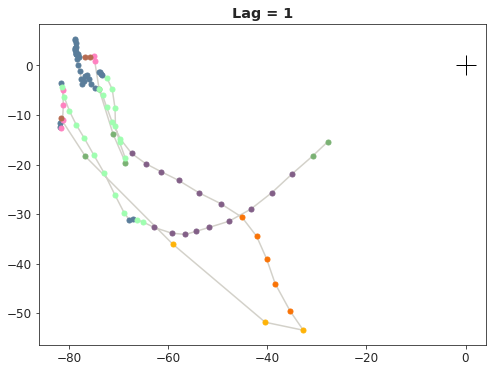

In [43]:
##===== Let's look at the states! =====##
iTrial = 7
data = data_list[iTrial]
mapseq = trMAPs[iTrial]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Lag = {}'.format(opt['AR_lags']))
ax.plot(data[:,0],data[:,1],'-',color=usrplt.cc[-1],alpha=0.5)


for state in np.unique(mapseq):
    indy = np.where(mapseq == state)[0]
    ax.plot(data[indy,0],data[indy,1],'.',color=usrplt.cc[state],ms=10)

ax.plot(0,0,'+k',ms=20)
ax.set_aspect('equal', adjustable='box',share=True)



In [ ]:
## Calculate & plot state duration and state usage 
usrplt.plot_state_durations2(state_duration_list,state_usage, K,
                            SAVEFIG=True,PlotDir=SaveDir,fname='state-durations_{}.pdf'.format(fname_sffx))

#Plot dynamics of latent states
if opt['AR_lags'] == 1:
    usrplt.plot_dynamics_2d(arhmm,SAVEFIG=True,PlotDir=SaveDir,fname='AR-streamplots_{}.pdf'.format(fname_sffx))

## Plot the actual AR matrices, with their corresponding fixed point
usrplt.plot_AR_matrices(arhmm, dsf=opt['downsample_factor'],SAVEFIG=True,PlotDir=SaveDir,fname='AR-matrices_{}.pdf'.format(fname_sffx))

## Plot example trajectories of actual trajectories for each state
usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, dsf=opt['downsample_factor'],
                                 longest=True, SAVEFIG=True,PlotDir=SaveDir,fname='state-trajectories_data_longest-trials_{}.pdf'.format(fname_sffx))

## Plot example trajectories of actual trajectories for each state
usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, dsf=opt['downsample_factor'],
                                 longest=False, SAVEFIG=True,PlotDir=SaveDir,fname='state-trajectories_data_varying-length_{}.pdf'.format(fname_sffx))

## Plot example trajectories simulated from the model for each state
usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, dsf=opt['downsample_factor'],
                                 simulated=True, SAVEFIG=True,PlotDir=SaveDir,fname='state-trajectories_simulated_longest-trials_{}.pdf'.format(fname_sffx))

## Plot example trajectories simulated from the model for each state
usrplt.plot_example_trajectories(state_duration_list, state_startend_list, mean_state_durations, data_list, arhmm, dsf=opt['downsample_factor'],
                                 longest=False, simulated=True, SAVEFIG=True,PlotDir=SaveDir,fname='state-trajectories_simulated_varying-length_{}.pdf'.format(fname_sffx))

#Calculate empirical transition count matrices
TCMs = util.get_transition_count_matrices(trMAPs,trMasks,K,normalize=False)
TPM = arhmm.transitions.transition_matrix

#Plot the TCMs per condition / success
usrplt.plot_transition_matrices_per_condition(TCMs, data_df, TPM, SAVEFIG=True, PlotDir=SaveDir,
                                              fname='transition-count-matrices_all-mice_{}.pdf'.format(fname_sffx))

#Plot the TCMs per mouse /condition / success 
usrplt.plot_transition_matrices_per_mouse(TCMs, data_df, TPM, SAVEFIG=True,PlotDir=SaveDir,
                                          fname='transition-count-matrices_per-mouse_{}.pdf'.format(fname_sffx))

## Plot example trajectories per trial
usrplt.plot_example_state_sequences(trMAPs, trMasks, data_list, K, nTrials_plot = 100,SAVEFIG=True,PlotDir=SaveDir,
                                    fname='state-sequences_{}.pdf'.format(fname_sffx))
